## Importing necessary libraries and packages

In [71]:
import torch
import torch.nn as nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from torch.optim import lr_scheduler
import math
import wandb
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split, Dataset
from torch.optim.lr_scheduler import LambdaLR
from sklearn.model_selection import train_test_split

## Making the most of my M2 MacBook Pro

In [72]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

device = 'mps' # 'cuda' if torch.cuda.is_available() else 'cpu'

## Getting the path to some relevent folders

In [73]:
checkpoints_path = '/Users/sienkadounia/lab/ai-futures/Project/ewdd/'
label_noise_path = '/Users/sienkadounia/lab/ai-futures/Project/label_noise/'
rlcts_path = '/Users/sienkadounia/lab/checkpoints/rlcts/ewdd/'

## List all hyperparameters in one cell for easy use

In [81]:
lr = 0.1
num_epochs = 2000
data_seed = 42
N = 1000 # Number of samples
D = 5  # Number of features

sigma = 0.5  # Noise
# Set the random seed and test size
RAND_ST = 42
test_size = 0.2
data_seed = 42
epochs = 1000

## Generating the training and testing data

In [82]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return x, y

In [83]:
# Let's create the data to train our DLN
# Generate feature matrix X and weight vector w
np.random.seed(data_seed)
X = np.random.randn(N, D)  # Samples from standard normal distribution
X = torch.from_numpy(X).float()

np.random.seed(data_seed)
W_true = np.random.randn(N, D) @ np.random.randn(D, N) # Weights from standard normal distribution
W_true = torch.from_numpy(W_true).float()

'''# Generate noise vector epsilon
np.random.seed(data_seed)
epsilon = sigma * np.random.randn(N)  # Noise from standard normal distribution
epsilon = torch.from_numpy(epsilon)'''

# Compute target variable y
#y = torch.matmul(X, w) + epsilon
y = W_true @ X

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RAND_ST)

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

## Building Deep Linear Network model architecture

In [84]:
# Define the neural network model
class RidgeRegressionNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RidgeRegressionNN, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size, bias=False)
        self.linear2 = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [85]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def lr_lambda(epoch):
    base_lr = 0.1
    return base_lr/math.sqrt(epoch+1)

## Training loop

In [86]:
# Train the model for a range of hidden layer sizes
hidden_layer_sizes = list(range(0, 200, 20))
train_errors = []
test_errors = []
params = []

for hidden_layer_size in hidden_layer_sizes:
    # Update the model architecture
    torch.manual_seed(data_seed)
    input_size = X_train.shape[-1]
    model = RidgeRegressionNN(input_size=input_size,
    hidden_size = input_size + hidden_layer_size,
    output_size=input_size).to(device)
    param = count_parameters(model)
    params.append(param)
    print(f'Number of model parameters is:  {param}')

    criterion = nn.MSELoss()
    # Define the optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)

    wandb.init(project="SLT of Double Descent", 
    config = {'epochs': num_epochs,
              'learning_rate': lr,
              'use_label_noise': 'False',
              'use_test_label_noise': 'False',
              'noise_level': '0',
              'dataset': "Toy Uniform Linear Regression",
              'architecture': "DLN",
              'model_width': count_parameters(model),
              'augmented': 'False',
              'optimizer': 'SGD'})

    wandb.watch(model)
    config = wandb.config

    # Training the model
    step = 0
    for epoch in range(epochs):
        model.train()
        model_train_errors = 0
        for _, data in enumerate(train_loader):
            X_train, y_train = data
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            optimizer.zero_grad()
            y_pred = model(X_train)
            loss = criterion(y_pred.squeeze(), y_train)
            model_train_errors+=loss.item()

            loss.backward()
            optimizer.step()
            
            step += 1
            wandb.log({'batch_loss': loss.item()}, step=step)
        
        model_train_error = model_train_errors / len(train_loader)
        train_errors.append(model_train_error)

        # Computing the training and testing errors
        model.eval()
        model_test_errors = 0
        with torch.no_grad():
            for _, data in enumerate(test_loader):
                X_test, y_test = data
                X_test = X_test.to(device)
                y_test = y_test.to(device)

                y_test_pred = model(X_test)
                test_error = criterion(y_test_pred, y_test)
                model_test_errors+=test_error.item()
                
        model_test_error = model_test_errors / len(test_loader)
        test_errors.append(model_test_error)

        wandb.log({'epoch': epoch,
                    'loss/train': model_train_error,
                    'loss/test': model_test_error,
                }, step=step)

torch.save(model.state_dict(), checkpoints_path + 'dln'+str(hidden_layer_size)+'.pth')

Number of model parameters is:  50


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


batch_loss,█▇▇▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,███▇▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,███▇▆▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,9.10723
epoch,80
loss/test,10.86866
loss/train,11.03247


Number of model parameters is:  250


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


batch_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,0.0
epoch,999
loss/test,0.0
loss/train,0.0


Number of model parameters is:  450


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


batch_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,0.0
epoch,999
loss/test,0.0
loss/train,0.0


Number of model parameters is:  650


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


batch_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,0.0
epoch,999
loss/test,0.0
loss/train,0.0


Number of model parameters is:  850


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


batch_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,0.0
epoch,999
loss/test,0.0
loss/train,0.0


Number of model parameters is:  1050


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


batch_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,0.0
epoch,999
loss/test,0.0
loss/train,0.0


Number of model parameters is:  1250


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


batch_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,0.0
epoch,999
loss/test,0.0
loss/train,0.0


Number of model parameters is:  1450


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


batch_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,0.0
epoch,999
loss/test,0.0
loss/train,0.0


Number of model parameters is:  1650


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


batch_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,0.0
epoch,999
loss/test,0.0
loss/train,0.0


Number of model parameters is:  1850


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


batch_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,0.0
epoch,999
loss/test,0.0
loss/train,0.0


In [25]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import einops
from einops import repeat

In [6]:
# Ploting the training and testing errors as a function of hidden layer size
dln_metrics = pd.read_csv('/Users/sienkadounia/lab/ai-futures/Project/mwdd/dln.csv')
dln_metrics

,epoch,dln_1650 - _step,dln_1650 - _step__MIN,dln_1650 - _step__MAX,dln_1650 - loss/test,dln_1650 - loss/test__MIN,dln_1650 - loss/test__MAX,dln_1450 - _step,dln_1450 - _step__MIN,dln_1450 - _step__MAX,...,dln_250 - _step__MAX,dln_250 - loss/test,dln_250 - loss/test__MIN,dln_250 - loss/test__MAX,dln_50 - _step,dln_50 - _step__MIN,dln_50 - _step__MAX,dln_50 - loss/test,dln_50 - loss/test__MIN,dln_50 - loss/test__MAX
0,0,7,7,7,4.639969e+03,4.639969e+03,4.639969e+03,7,7,7,...,7,4.906116e+03,4.906116e+03,4.906116e+03,7,7,7,4.947001e+03,4.947001e+03,4.947001e+03
1,1,14,14,14,4.174549e+03,4.174549e+03,4.174549e+03,14,14,14,...,14,4.783263e+03,4.783263e+03,4.783263e+03,14,14,14,4.860770e+03,4.860770e+03,4.860770e+03
2,2,21,21,21,3.580758e+03,3.580758e+03,3.580758e+03,21,21,21,...,21,4.589557e+03,4.589557e+03,4.589557e+03,21,21,21,4.735161e+03,4.735161e+03,4.735161e+03
3,3,28,28,28,2.824672e+03,2.824672e+03,2.824672e+03,28,28,28,...,28,4.282504e+03,4.282504e+03,4.282504e+03,28,28,28,4.519227e+03,4.519227e+03,4.519227e+03
4,4,35,35,35,2.020039e+03,2.020039e+03,2.020039e+03,35,35,35,...,35,3.807370e+03,3.807370e+03,3.807370e+03,35,35,35,4.169806e+03,4.169806e+03,4.169806e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,6972,6972,6972,1.304225e-09,1.304225e-09,1.304225e-09,6972,6972,6972,...,6972,1.522841e-09,1.522841e-09,1.522841e-09,6972,6972,6972,1.493949e-09,1.493949e-09,1.493949e-09
996,996,6979,6979,6979,1.306097e-09,1.306097e-09,1.306097e-09,6979,6979,6979,...,6979,1.522064e-09,1.522064e-09,1.522064e-09,6979,6979,6979,1.494010e-09,1.494010e-09,1.494010e-09
997,997,6986,6986,6986,1.302100e-09,1.302100e-09,1.302100e-09,6986,6986,6986,...,6986,1.522508e-09,1.522508e-09,1.522508e-09,6986,6986,6986,1.495109e-09,1.495109e-09,1.495109e-09
998,998,6993,6993,6993,1.309460e-09,1.309460e-09,1.309460e-09,6993,6993,6993,...,6993,1.522127e-09,1.522127e-09,1.522127e-09,6993,6993,6993,1.493435e-09,1.493435e-09,1.493435e-09


In [75]:
model_ref = ['dln_50 - loss/test', 'dln_250 - loss/test', 'dln_450 - loss/test', 'dln_650 - loss/test', 'dln_850 - loss/test', 'dln_1050 - loss/test', 'dln_1250 - loss/test', 'dln_1450 - loss/test', 'dln_1650 - loss/test']
model_fig = ['dln_50', 'dln_250', 'dln_450', 'dln_650', 'dln_850', 'dln_1050', 'dln_1250', 'dln_1450', 'dln_1650']

model_losses = []
for i in model_ref:
    model_loss = dln_metrics[i].values
    model_losses.append(model_loss.transpose())

In [76]:
model_losses

[array([4.94700098e+03, 4.86077026e+03, 4.73516089e+03, 4.51922656e+03,
        4.16980591e+03, 3.66495874e+03, 2.99745959e+03, 2.30672559e+03,
        1.72222528e+03, 1.32281372e+03, 1.03607648e+03, 8.14700623e+02,
        6.43055206e+02, 4.98814835e+02, 3.84058304e+02, 2.91693123e+02,
        2.20842010e+02, 1.68162132e+02, 1.28092785e+02, 9.70216103e+01,
        7.12296066e+01, 5.31255035e+01, 3.91008511e+01, 2.95098000e+01,
        2.28513823e+01, 1.82802906e+01, 1.51265168e+01, 1.30606837e+01,
        1.17314405e+01, 1.08491693e+01, 1.02646632e+01, 9.88962698e+00,
        9.60349035e+00, 9.36593914e+00, 9.20091486e+00, 9.03957081e+00,
        8.93168402e+00, 8.80459166e+00, 8.71492243e+00, 8.60303473e+00,
        8.49758911e+00, 8.40535712e+00, 8.28629780e+00, 8.15024233e+00,
        8.06027699e+00, 7.98060346e+00, 7.89196229e+00, 7.79212999e+00,
        7.65314651e+00, 7.57801557e+00, 7.43140125e+00, 7.32157516e+00,
        7.16606069e+00, 7.06562257e+00, 6.95222712e+00, 6.826009

In [77]:
epoch = list(range(1, 1001))
epochs = repeat(np.array(epoch), 'w -> 10 w')
epochs

array([[   1,    2,    3, ...,  998,  999, 1000],
       [   1,    2,    3, ...,  998,  999, 1000],
       [   1,    2,    3, ...,  998,  999, 1000],
       ...,
       [   1,    2,    3, ...,  998,  999, 1000],
       [   1,    2,    3, ...,  998,  999, 1000],
       [   1,    2,    3, ...,  998,  999, 1000]])

In [78]:
golden_ratio = (5**0.5 - 1) / 2
WIDTH = 3.25
HEIGHT = WIDTH * golden_ratio
some_multiplier_1 = 3
some_multiplier_2 = 3

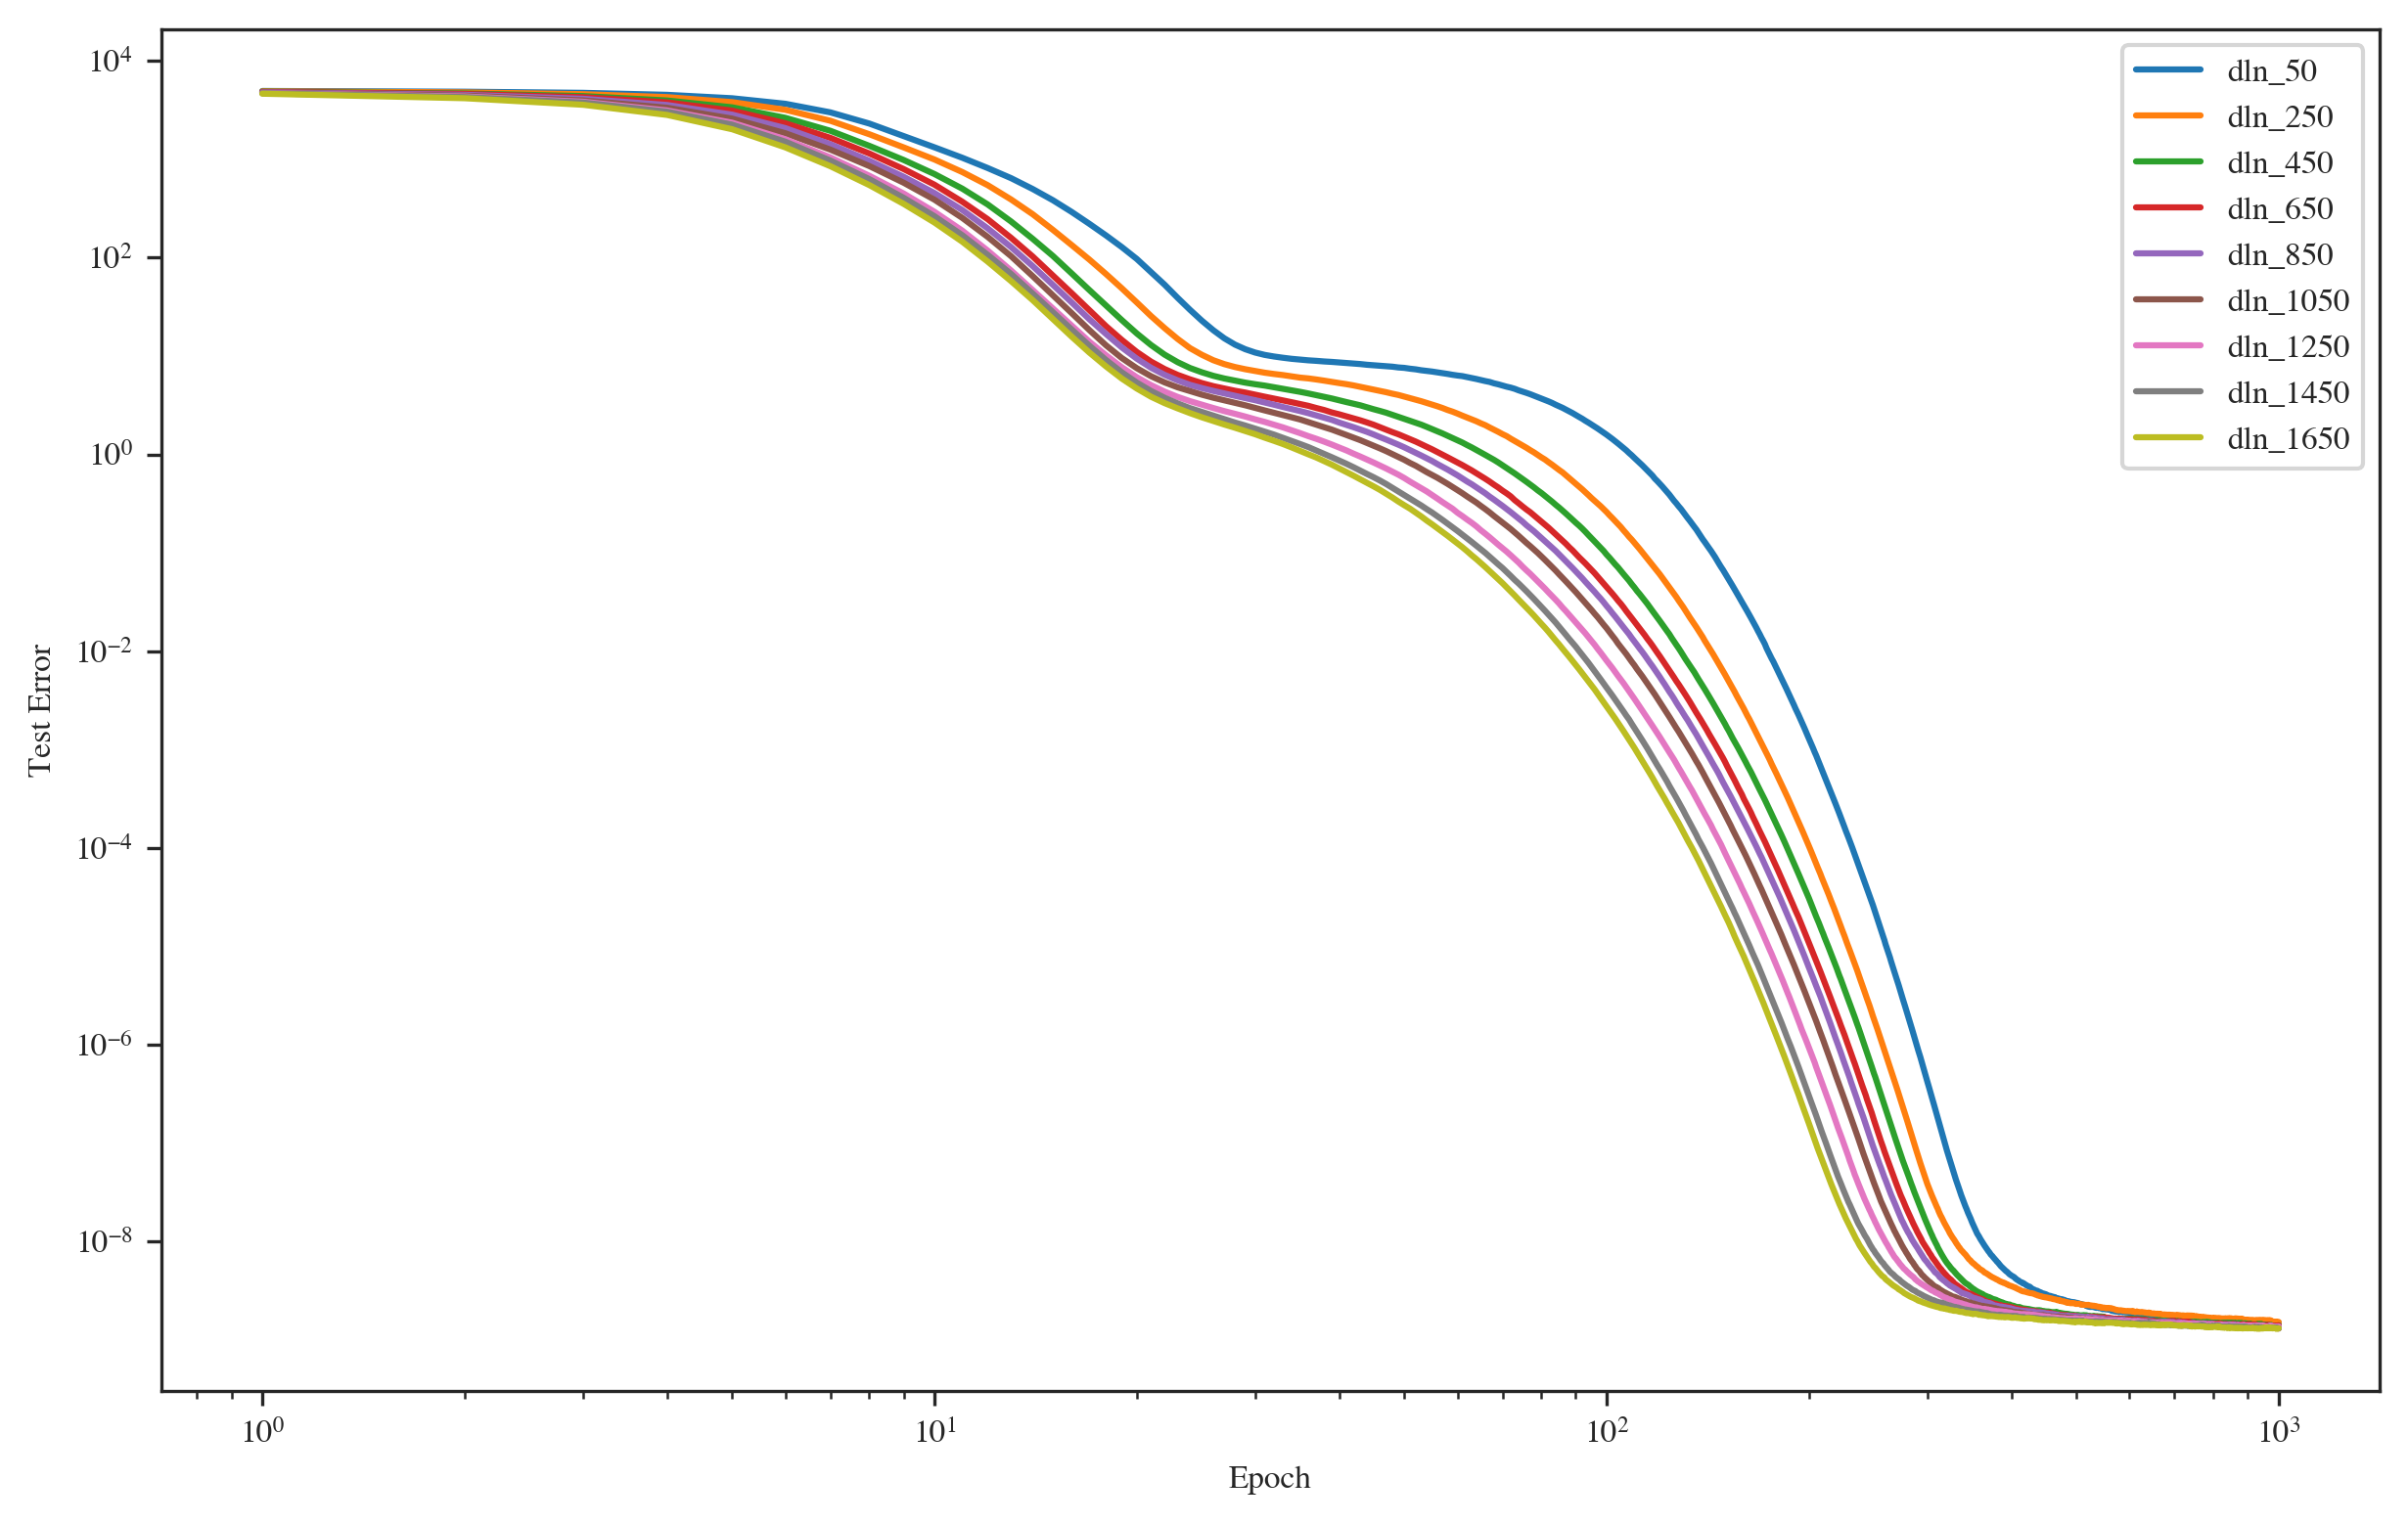

In [79]:
plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))
plt.plot(epoch, model_losses[0])
plt.plot(epoch, model_losses[1])
plt.plot(epoch, model_losses[2])
plt.plot(epoch, model_losses[3])
plt.plot(epoch, model_losses[4])
plt.plot(epoch, model_losses[5])
plt.plot(epoch, model_losses[6])
plt.plot(epoch, model_losses[7])
plt.plot(epoch, model_losses[8])
#plt.plot(epoch, model_losses[9])
plt.xscale('log')
plt.yscale('log')

plt.ylabel('Test Error')
plt.xlabel('Epoch')
plt.legend(labels = model_fig, loc="upper right")
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)

#plt.savefig("ten_percent_losses.pdf")
plt.show()

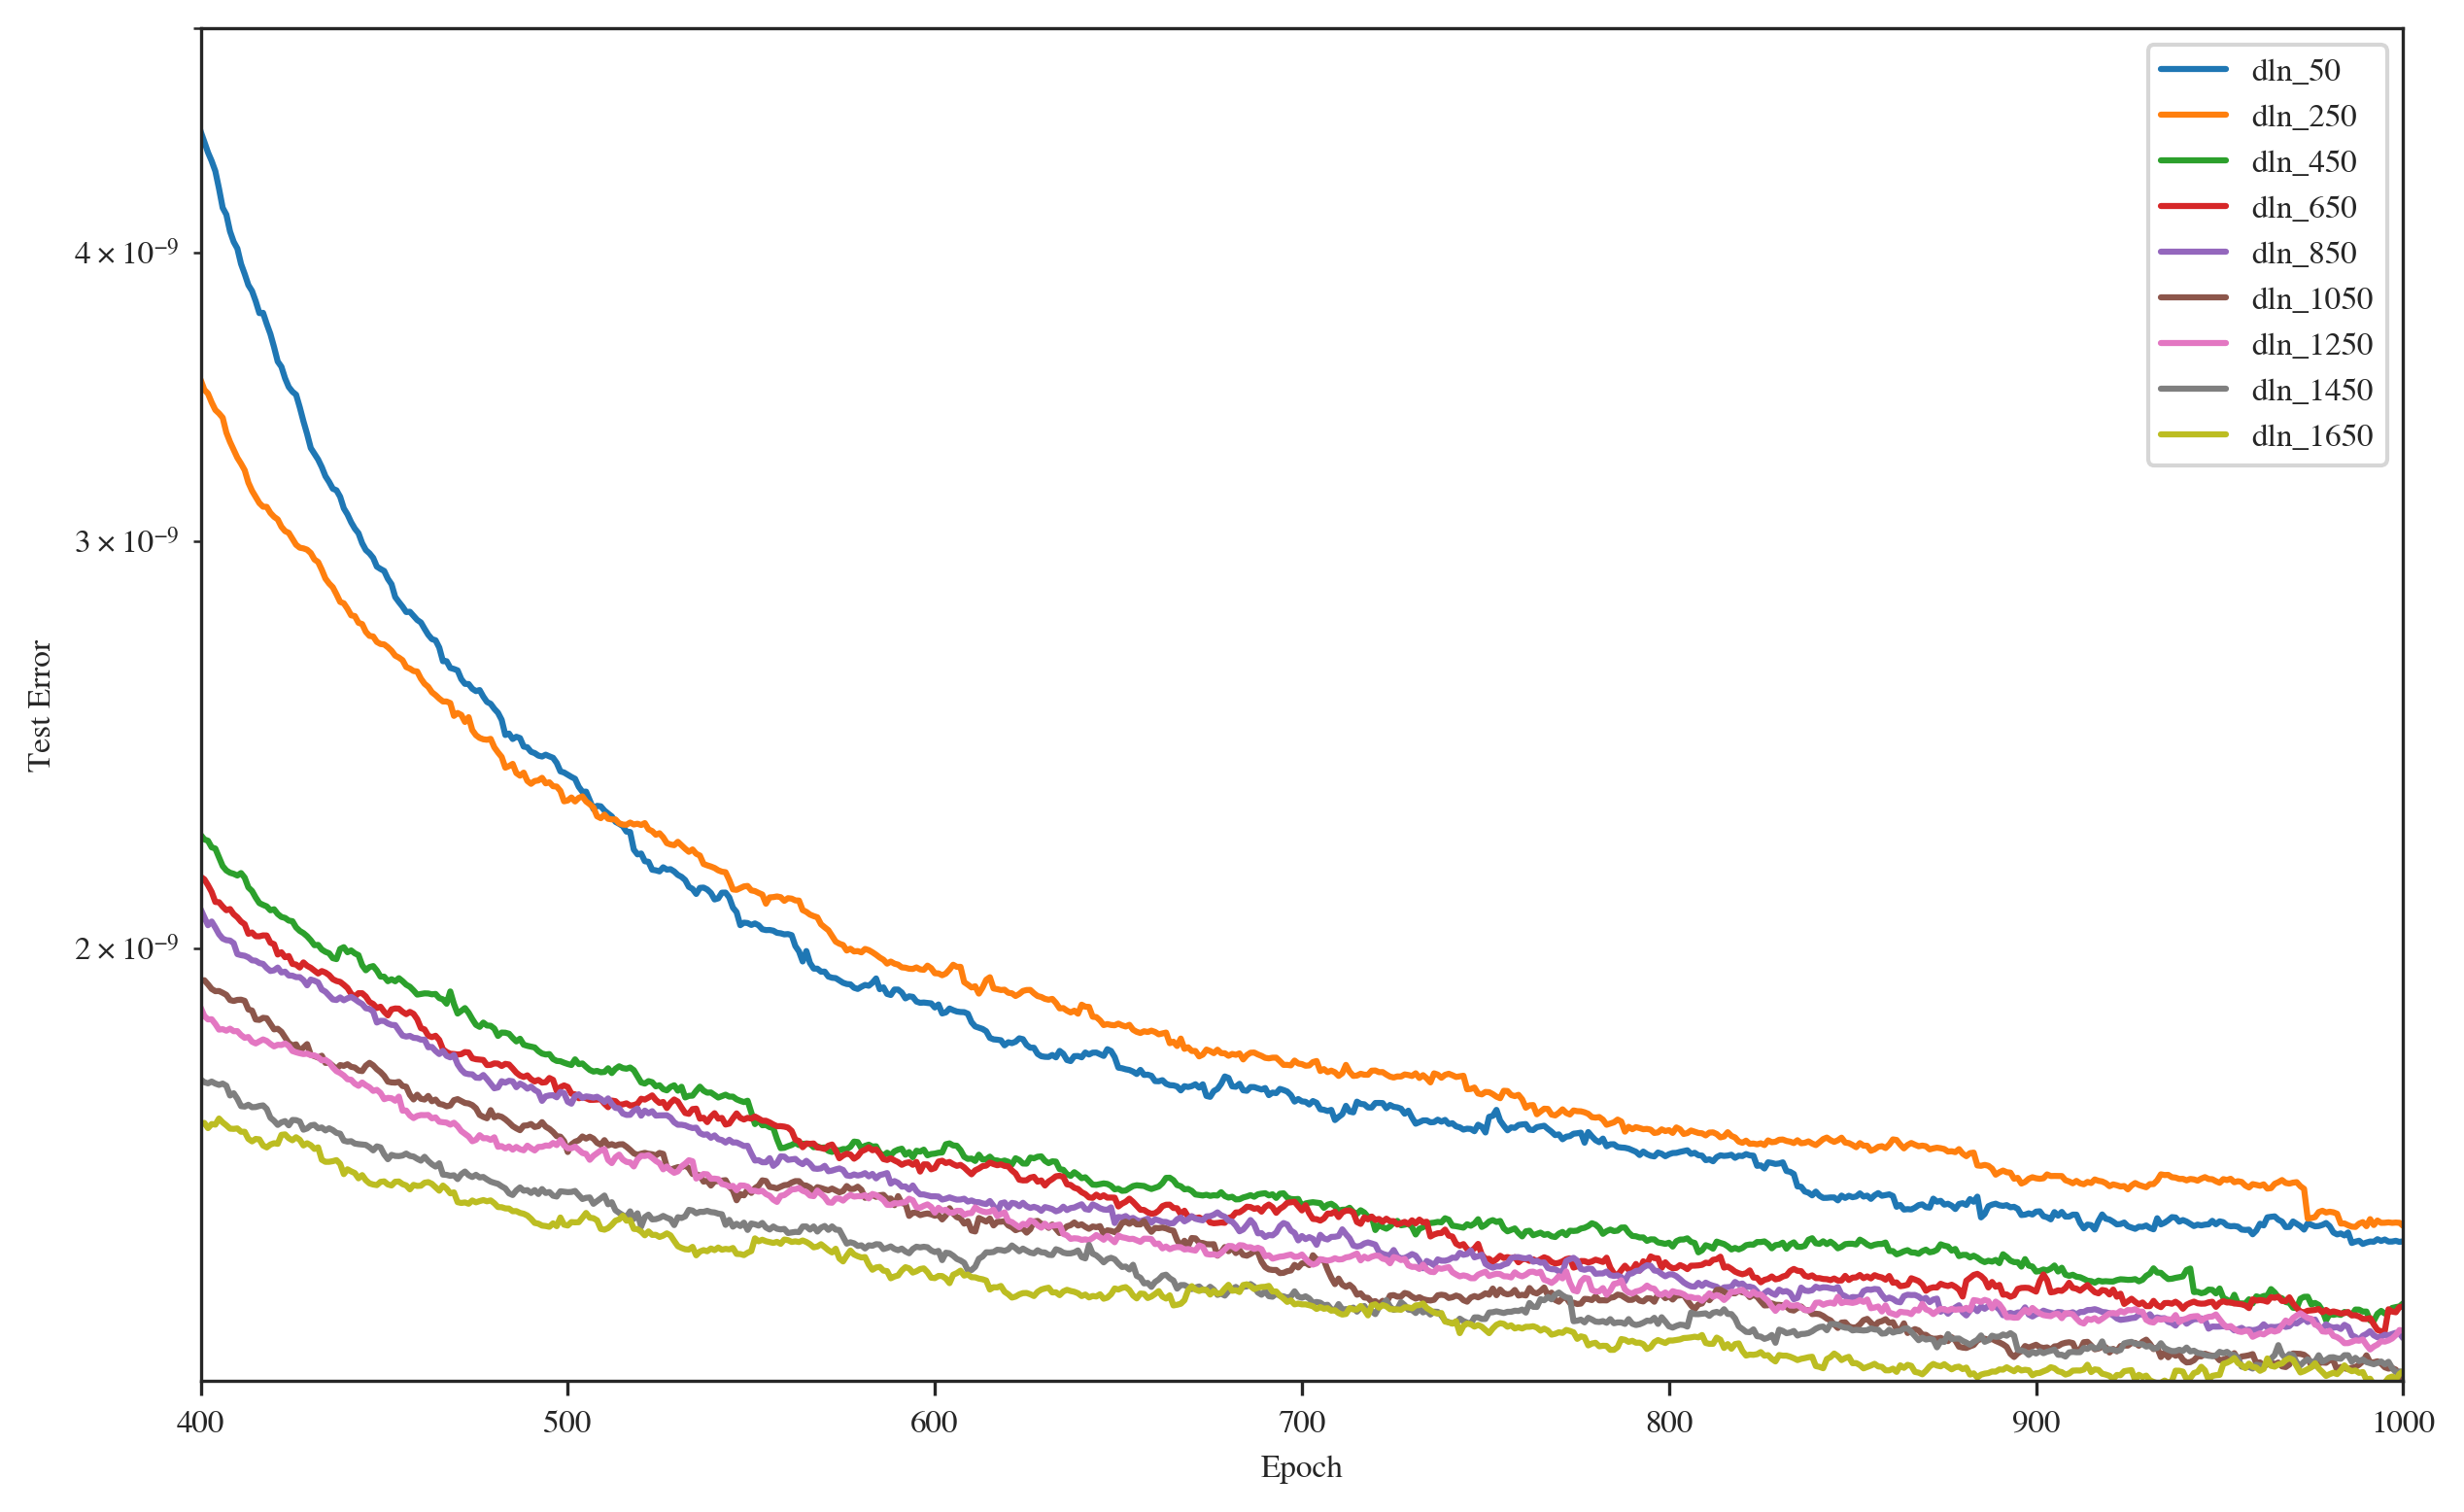

In [81]:
plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))
plt.plot(epoch, model_losses[0])
plt.plot(epoch, model_losses[1])
plt.plot(epoch, model_losses[2])
plt.plot(epoch, model_losses[3])
plt.plot(epoch, model_losses[4])
plt.plot(epoch, model_losses[5])
plt.plot(epoch, model_losses[6])
plt.plot(epoch, model_losses[7])
plt.plot(epoch, model_losses[8])
#plt.plot(epoch, model_losses[9])
#plt.xscale('log')
plt.yscale('log')

plt.ylabel('Test Error')
plt.xlabel('Epoch')
plt.legend(labels = model_fig, loc="upper right")
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.xlim([400, 1000])
plt.ylim([1.3*(10**-9),5*(10**-9)])
#plt.savefig("ten_percent_losses.pdf")
plt.show()

In [ ]:
plt.plot(params, test_errors, label='Testing error')
plt.plot(params, train_errors, label='Training error')
plt.axvline(x=N, color='r', linestyle='--', label='Model parameters= Number of samples')
plt.xlabel('Parameters')
plt.ylabel('MSE')
plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.show()